In [11]:
def run_energy_forecast_pipeline():
    import pandas as pd
    import joblib
    import os
    import matplotlib.pyplot as plt
    from xgboost import XGBRegressor
    from sklearn.metrics import mean_squared_error
    from math import sqrt
    import warnings
    warnings.filterwarnings("ignore")

    # Step 1: Load dataset
    data_path = r"C:\Users\willi\GitHub\TS_Energy_Consumption_XGB\data\raw\PJME_hourly.csv"
    PJME_data = pd.read_csv(data_path, index_col='Datetime', parse_dates=True)

    # Step 2: Create features
    def create_features(df):
        df = df.copy()
        df["hour"] = df.index.hour
        df["dayofweek"] = df.index.dayofweek
        df["quarter"] = df.index.quarter
        df["month"] = df.index.month
        df["dayofyear"] = df.index.dayofyear
        df["year"] = df.index.year
        return df

    PJME_data = create_features(PJME_data)

    FEATURES = ["hour", "dayofweek", "quarter", "month", "dayofyear", "year"]
    TARGET = "PJME_MW"

    # Step 3: Train/test split
    split_date = "2015-01-01"
    train = PJME_data[PJME_data.index < split_date]
    test = PJME_data[PJME_data.index >= split_date]

    X_train = train[FEATURES]
    y_train = train[TARGET]
    X_test = test[FEATURES]
    y_test = test[TARGET]

    # Step 4: Train model
    model = XGBRegressor(
        objective='reg:squarederror',
        learning_rate=0.01,
        max_depth=3,
        n_estimators=1000,
        subsample=0.8,
        colsample_bytree=1.0,
        eval_metric='rmse',
        early_stopping_rounds=20
    )
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    # Step 5: Evaluate and print RMSE
    test['prediction'] = model.predict(X_test)
    rmse = sqrt(mean_squared_error(test[TARGET], test['prediction']))
    print(f"📉 RMSE on test set: {rmse:.2f}")

    # Step 6: Forecast future 7 days (hourly)
    future_dates = pd.date_range(
        start=PJME_data.index.max() + pd.Timedelta(hours=1),
        periods=24 * 7,
        freq='H'
    )
    future_df = pd.DataFrame(index=future_dates)
    future_df = create_features(future_df)
    future_df['forecast'] = model.predict(future_df[FEATURES])

    # Step 7: Save model and forecast
    model_output_path = r"C:\Users\willi\GitHub\TS_Energy_Consumption_XGB\models\xgb_model.joblib"
    forecast_output_path = r"C:\Users\willi\GitHub\TS_Energy_Consumption_XGB\reports\7_day_forecast.csv"
    joblib.dump(model, model_output_path)
    future_df.to_csv(forecast_output_path)
    print(f"✅ Model saved to {model_output_path}")
    print(f"✅ Forecast saved to {forecast_output_path}")

    # Step 8: Plot results
 # Get the last 7 days from the actuals before the forecast starts
    PJME_data = PJME_data.sort_index()

# Safely get the last 7 days of actuals before the forecast
    forecast_start = future_df.index.min()
    actual_window = PJME_data.loc[:forecast_start].last("7D")

# Plot actual + forecast aligned
    plt.figure(figsize=(15, 5))
    plt.plot(actual_window.index, actual_window['PJME_MW'], label='Actual (Last 7 Days)')
    plt.plot(future_df.index, future_df['forecast'], label='Forecast (Next 7 Days)', linestyle='--')
    plt.title('7-Day Energy Forecast')
    plt.xlabel('Datetime')
    plt.ylabel('MW')
    plt.legend()
    plt.tight_layout()
    plt.show()


📉 RMSE on test set: 3743.56
✅ Model saved to C:\Users\willi\GitHub\TS_Energy_Consumption_XGB\models\xgb_model.joblib
✅ Forecast saved to C:\Users\willi\GitHub\TS_Energy_Consumption_XGB\reports\7_day_forecast.csv


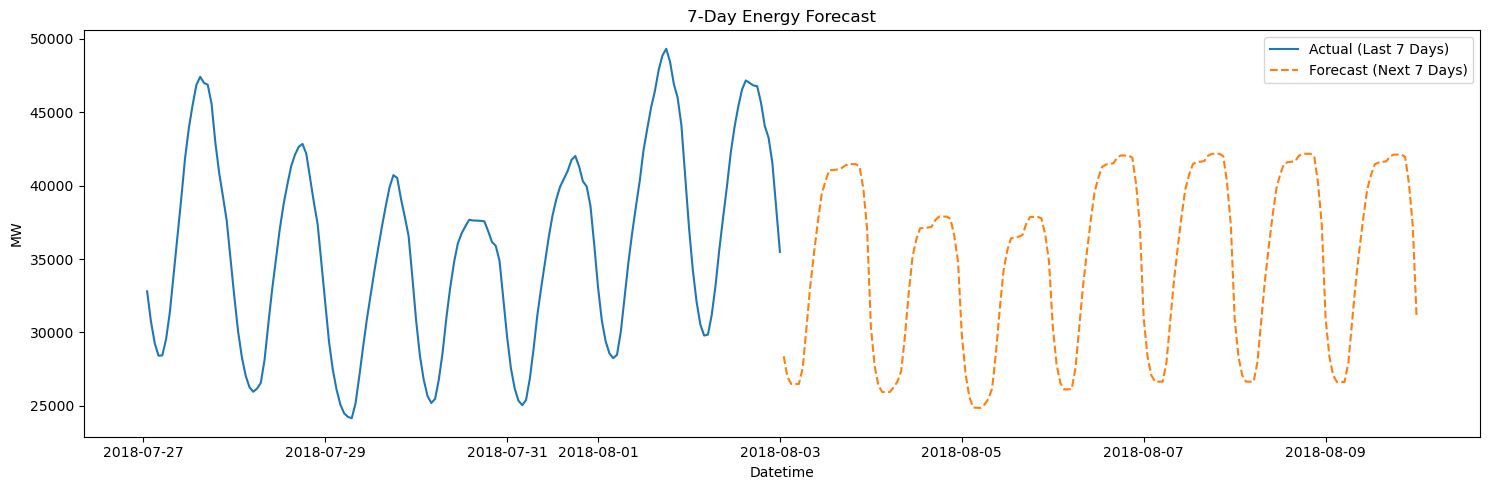

In [12]:
run_energy_forecast_pipeline()
